In [15]:
import numpy as np
import pandas as pd
import networkx as nx

import sys

sys.path.append("../")
import utils
from gcn_models import GIN, GATC, SAGE

from os import path
import torch
import os
import numpy as np

import torch
import torch.nn.functional as F

from torch_geometric.loader import DataLoader
from sklearn.metrics import f1_score, accuracy_score

import warnings

warnings.filterwarnings("ignore")

In [16]:
early_stop_thresh = 25
best_macro_f1 = -1


train_dataset = utils.GraphDataset("../data/", "GunPoint", True, True, n_quantiles=40)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

test_dataset = utils.GraphDataset("../data/", "GunPoint", False, True, n_quantiles=40)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

for elem in train_dataset:
    break
elem

(50, 150)
(150, 150)


Data(edge_index=[2, 121], weight=[121], x=[40, 14], y=1, edge_attr=[121, 1])

In [17]:
model = GIN(14, [10, 10, 10], out_channels=2, num_layers=1, pool_method="avg")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [18]:
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        y_out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = F.cross_entropy(y_out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader, return_loss=True):
    model.eval()
    y_pred = []
    y_true = []
    loss = 0
    for data in loader:
        y_out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        y_pred.append(y_out.argmax(dim=-1))
        y_true.append(data.y)
        if return_loss:
            loss += float(F.cross_entropy(y_out, data.y)) * data.num_graphs
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    if return_loss:
        return (
            f1_score(y_true=y_true, y_pred=y_pred, average="macro"),
            accuracy_score(y_true=y_true, y_pred=y_pred),
            loss / len(loader.dataset),
        )
    return f1_score(y_true=y_true, y_pred=y_pred, average="macro"), accuracy_score(
        y_true=y_true, y_pred=y_pred
    )

In [19]:
train_losses = []
val_losses = []
best_model = None
for epoch in range(1301):
    train()
    train_macro_f1, train_acc, train_loss = test(train_loader)
    test_macro_f1, test_acc, test_loss = test(test_loader, True)
    print(
        f"Epoch: {epoch:03d}, Train_Loss: {train_loss:02.4f},Test_Loss: {test_loss:02.4f},Train_f1: {train_macro_f1:01.4f},Test_f1: {test_macro_f1:01.4f},Train_acc: {train_acc:01.4f},Test_acc: {test_acc:01.4f}"
    )
    train_losses.append(train_loss)
    val_losses.append(test_loss)
    if test_macro_f1 > best_macro_f1:
        best_accuracy = test_macro_f1
        best_epoch = epoch
        best_model = (epoch, model.state_dict())
        torch.save(model.state_dict(), f"../data/PoC_GCNs.pth")
    elif epoch - best_epoch > early_stop_thresh:
        print(
            f"Early stopped training at epoch {epoch} best macro F1 {best_macro_f1} in {best_epoch}"
        )
        break

Epoch: 000, Train_Loss: 43.7611,Test_Loss: 39.1743,Train_f1: 0.3243,Test_f1: 0.3363,Train_acc: 0.4800,Test_acc: 0.5067
Epoch: 001, Train_Loss: 42.8273,Test_Loss: 38.3089,Train_f1: 0.3243,Test_f1: 0.3363,Train_acc: 0.4800,Test_acc: 0.5067
Epoch: 002, Train_Loss: 41.8944,Test_Loss: 37.4404,Train_f1: 0.3243,Test_f1: 0.3363,Train_acc: 0.4800,Test_acc: 0.5067
Epoch: 003, Train_Loss: 40.9593,Test_Loss: 36.5707,Train_f1: 0.3243,Test_f1: 0.3363,Train_acc: 0.4800,Test_acc: 0.5067
Epoch: 004, Train_Loss: 40.0201,Test_Loss: 35.6993,Train_f1: 0.3243,Test_f1: 0.3363,Train_acc: 0.4800,Test_acc: 0.5067
Epoch: 005, Train_Loss: 39.0782,Test_Loss: 34.8234,Train_f1: 0.3243,Test_f1: 0.3363,Train_acc: 0.4800,Test_acc: 0.5067
Epoch: 006, Train_Loss: 38.1355,Test_Loss: 33.9432,Train_f1: 0.3243,Test_f1: 0.3363,Train_acc: 0.4800,Test_acc: 0.5067
Epoch: 007, Train_Loss: 37.1912,Test_Loss: 33.0623,Train_f1: 0.3243,Test_f1: 0.3363,Train_acc: 0.4800,Test_acc: 0.5067
Epoch: 008, Train_Loss: 36.2464,Test_Loss: 32.18

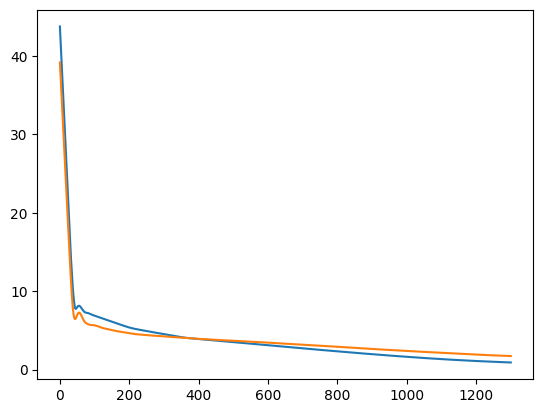

In [20]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

In [21]:
torch.save(model.state_dict(), f"../data/PoC_GCNs.pth")